Importing necessrary libraries

In [1]:
import numpy as np
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

Generating Data randomly with a nonlinear calculation method for target

In [2]:
n_samples = 2000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)
x4 = random_state.uniform(size=n_samples) 
X = np.c_[x1,x2,x3,x4]

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
Y = random_state.binomial(1, p, size=n_samples)

Standardizing and generating Train-Test Split

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.3, random_state=0)

Model Results Dict

In [4]:
Model_Results = {}

In [5]:
def num_misclassifications(y_true, y_pred):
    res = 0
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            res += 1
    return res

Sklearn Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR_model = LogisticRegression()
t_start = time.time()
LR_model.fit(X_train, Y_train)
t_end = time.time()

LR_training_time = t_end - t_start

Y_LR_Pred = LR_model.predict(X_train)
LR_train_accuracy = accuracy_score(Y_train, Y_LR_Pred)
LR_train_misclass = num_misclassifications(Y_train, Y_LR_Pred)

Y_LR_Pred_t = LR_model.predict(X_test)
LR_test_accuracy = accuracy_score(Y_test, Y_LR_Pred_t)
LR_test_misclass = num_misclassifications(Y_test, Y_LR_Pred_t)


Model_Results["Logistic Regression"] = (LR_train_accuracy, LR_train_misclass, LR_test_accuracy, LR_test_misclass, LR_training_time)
print(Model_Results["Logistic Regression"])

(0.745, 357, 0.72, 168, 0.005649566650390625)


SVM

In [7]:
from sklearn.svm import SVC

SVM_model = SVC()
t_start = time.time()
SVM_model.fit(X_train, Y_train)
t_end = time.time()

SVM_training_time = t_end - t_start

Y_SVM_Pred = SVM_model.predict(X_train)
SVM_train_accuracy = accuracy_score(Y_train, Y_SVM_Pred)
SVM_train_misclass = num_misclassifications(Y_train, Y_SVM_Pred)

Y_SVM_Pred_t = SVM_model.predict(X_test)
SVM_test_accuracy = accuracy_score(Y_test, Y_SVM_Pred_t)
SVM_test_misclass = num_misclassifications(Y_test, Y_SVM_Pred_t)

Model_Results["SVM"] = (SVM_train_accuracy, SVM_train_misclass, SVM_test_accuracy, SVM_test_misclass, SVM_training_time)
print(Model_Results["SVM"])

(0.7628571428571429, 332, 0.715, 171, 0.05727887153625488)


LGBM

In [8]:
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

LGB_train = lgb.Dataset(X_train, Y_train)
LGB_test = lgb.Dataset(X_test, Y_test)

## defaults num_leaves = 31,
params = {'force_col_wise': True, 'boosting_type': 'gbdt', 'num_iterations': 100,
         'n_estimators': 100, 'max_depth': 5, 'num_leaves': 100, 'feature_fraction': 0.75,
         'bagging_fraction': 0.75, 'bagging_freq': 1, 'lambda': 0.5, 'random_state': 3, 'verbose': -1}

t_start = time.time()
LGB_model = lgb.train(params, LGB_train, valid_sets=[LGB_train, LGB_test])
t_end = time.time()

LGB_training_time = t_end - t_start

Y_LGB_Pred = LGB_model.predict(X_train)
Y_LGB_Pred = np.where(Y_LGB_Pred<0.5,0,1)
LGB_train_accuracy = accuracy_score(Y_train, Y_LGB_Pred)
LGB_train_misclass = num_misclassifications(Y_train, Y_LGB_Pred)

Y_LGB_Pred_t = LGB_model.predict(X_test)
Y_LGB_Pred_t = np.where(Y_LGB_Pred_t<0.5,0,1)
LGB_test_accuracy = accuracy_score(Y_test, Y_LGB_Pred_t)
LGB_test_misclass = num_misclassifications(Y_test, Y_LGB_Pred_t)

Model_Results["LGB"] = (LGB_train_accuracy, LGB_train_misclass, LGB_test_accuracy, LGB_test_misclass, LGB_training_time)
print(Model_Results["LGB"])

(0.8535714285714285, 205, 0.705, 177, 0.11307382583618164)


Pytorch

99 17.5
199 8.125
299 3.78125
399 1.875
499 0.9375
599 0.59375
699 0.40625
799 0.1875
899 0.15625
999 0.1875
1099 0.15625
1199 0.0625
1299 0.03125
1399 0.03125
1499 0.125
1599 0.0625
1699 0.03125
1799 0.125
1899 0.0625


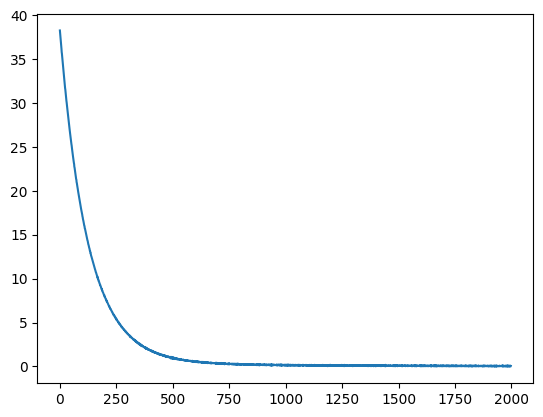

In [14]:
import matplotlib.pyplot as plt

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32)

D_in, H1, H2, D_out = 4, 10, 10, 1

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out), 
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-8
last = 1.0
error = 1.0
t = 0
errors = []
epochs = 2000

while (t<epochs):
    y_pred = model(X_train_torch)

    loss = loss_fn(y_pred, Y_train_torch)
    if t % 100 == 99:
        print(t, error)

    model.zero_grad()

    loss.backward()
    error = abs(last-loss.item())
    last = loss.item()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    errors.append(error)
    t += 1
    if (t == epochs-1): break

plt.plot(errors[1:])




In [17]:
import pandas as pd

Results = pd.DataFrame.from_dict(Model_Results, orient='index', columns= ["Train Accuracy","Train Misclass", "Test Accuracy", "Test Misclass", "train Time"])
display(Results)

,Train Accuracy,Train Misclass,Test Accuracy,Test Misclass,train Time
Logistic Regression,0.745000,357,0.720,168,0.005650
SVM,0.762857,332,0.715,171,0.057279
LGB,0.853571,205,0.705,177,0.113074
